In [229]:
%matplotlib inline
import numpy as np
import pandas as pd
from keras.models import load_model
from glob import glob
from keras import backend as K
import matplotlib.pyplot as plt
from os.path import join
from scipy.ndimage import gaussian_filter, maximum_filter, median_filter
from IPython.display import Image
import yaml
import xarray as xr
import traceback
from deepsky.gan import normalize_multivariate_data
from deepsky.data import load_storm_patch_data
from hagelslag.evaluation import DistributedROC, DistributedReliability, roc_curve
#from hagelslag.evaluation import reliability_diagram, performance_diagram, attributes_diagram
from hagelslag.evaluation.ProbabilityMetrics import bootstrap
from multiprocessing import Pool
from skimage.morphology import disk
from scipy.ndimage import minimum_filter, maximum_filter
from os.path import getctime
import yaml

In [68]:
out_path = "/scratch/dgagne/spatial_storm_results_20171220/"
sample = 3
model_name = "hail_conv_net_sample_{0:03d}.h5".format(sample)
hail_conv_net = load_model(join(out_path, model_name))

In [99]:
ctimes = np.zeros(30)
for i in range(30):
    ctimes[i] = getctime(join(out_path, "hail_logistic_mean_sample_{0:03d}.pkl".format(i)))

In [82]:
ctimes = np.zeros(30)
for i in range(30):
    ctimes[i] = getctime(join(out_path, "logistic_gan_{0:0d}_encoder.h5".format(i)))

In [106]:
np.mean(ctimes[1:] - ctimes[:-1]) /  60 * 30 / 60

0.32356321839080465

15.0

In [89]:
93 * 30 / 60

46.5

In [69]:
hail_conv_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

In [10]:
hail_conv_net.layers[1].output

<tf.Tensor 'conv2d_1/BiasAdd:0' shape=(?, 16, 16, 32) dtype=float32>

In [476]:
hail_conv_net.layers[-7].get_weights()[0].argmax()

143983

(array([  15.,   80.,  272.,  345.,  369.,  335.,  333.,  210.,   75.,   14.]),
 array([-0.05220393, -0.0412923 , -0.03038068, -0.01946905, -0.00855742,
         0.0023542 ,  0.01326583,  0.02417746,  0.03508909,  0.04600071,
         0.05691234]),
 <a list of 10 Patch objects>)

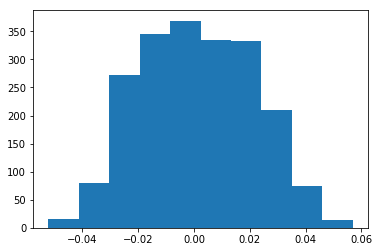

In [483]:
plt.hist(hail_conv_net.layers[-2].get_weights()[0][:, 0])

In [452]:
hail_conv_net.layers[-7]

In [442]:
hail_conv_net.layers[-7].get_weights()[0].shape

(5, 5, 64, 128)

In [444]:
np.unravel_index(1927,(1,4,4,128))

(0, 3, 3, 7)

In [64]:
def visualize_layer(cnn_model, out_prob, num_iter=25, dropout=False):
    layer_out = cnn_model.output
    input_image = cnn_model.input
    loss = (out_prob - layer_out) ** 2
    grads = K.gradients(loss, input_image)[0]
    grads /= K.maximum(K.std(grads), 1e-5)
    #grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [loss, grads])
    input_img_data = np.zeros((1, 32, 32, 15))
    #input_img_data = np.random.normal(size=(1, 32, 32, 15)) * 0.1
    step = 0.001
    for i in range(num_iter):
        loss_value, grads_value = iterate([input_img_data, dropout])
        input_img_data -= grads_value * step
    return input_img_data

def vis_act(cnn_model, input_data):
    layer_out = cnn_model.layers[1].output
    input_image = cnn_model.layers[0].input
    func = K.function([input_image, K.learning_phase()], [layer_out])
    return func([input_data, False])

def smooth_channels(storm_cube):
    smooth_cube = np.zeros(storm_cube.shape)
    ds = disk(2)
    for c in range(storm_cube.shape[-1]):
        out_channel = storm_cube[0, :, :, c]
        out_smooth = gaussian_filter(out_channel, 2)
        out_pos = np.zeros(out_channel.shape)
        out_neg = np.zeros(out_channel.shape)
        out_pos[out_smooth > 0] = out_channel[out_smooth > 0]
        out_neg[out_smooth < 0] = out_channel[out_smooth < 0]
        max_pos = maximum_filter(out_pos, footprint=ds)
        min_neg = minimum_filter(out_neg, footprint=ds)
        out_proc = np.zeros(out_channel.shape)
        out_proc[out_smooth > 0] = max_pos[out_smooth > 0]
        out_proc[out_smooth < 0] = min_neg[out_smooth < 0]
        smooth_cube[:, :, :, c] = out_proc
        smooth_cube[:, :, :, c] = gaussian_filter(smooth_cube[:, :, :, c], 1)
        #smooth_cube[:, :, :, c] = maximum_filter(storm_cube[:, :, :, c], filter_sd)
        #smooth_cube[:, :, :, c] /= smooth_cube[:, :, :, c].std()
    return smooth_cube

def predict_sample(cnn_model, input_data, num_samples):
    layer_out = cnn_model.layers[-1].output
    input_image = cnn_model.layers[0].input
    func = K.function([input_image, K.learning_phase()], [K.flatten(layer_out)])
    preds = []
    for i in range(num_samples):
        preds.append(np.ravel(func([input_data, True])))
    return preds

In [297]:
hail_conv_net.output

<tf.Tensor 'activation_4/Sigmoid:0' shape=(?, 1) dtype=float32>

In [ ]:
vis_samples = []
for i in range(30):
    vis_samples.append(visualize_layer(hail_conv_net, 1, num_iter=15, dropout=True))
all_vis_samples = np.vstack(vis_samples)


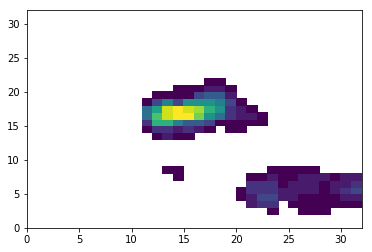

In [294]:
freq_chart = np.zeros((32, 32))
for i in range(30):
    h = gaussian_filter(all_vis_samples[i, :, :, 0], 2)
    freq_chart += np.where(h / h.std() <= -2, 1, 0)
plt.pcolormesh(np.ma.array(freq_chart, mask=freq_chart== 0))

In [193]:
all_preds = np.array(predict_sample(hail_conv_net, norm_data, 30))

(array([ 267.,   50.,   35.,   20.,   17.,    6.,    5.,   11.,   14.,   24.]),
 array([  1.56908955e-05,   9.98208299e-02,   1.99625969e-01,
          2.99431108e-01,   3.99236247e-01,   4.99041386e-01,
          5.98846525e-01,   6.98651664e-01,   7.98456803e-01,
          8.98261942e-01,   9.98067081e-01]),
 <a list of 10 Patch objects>)

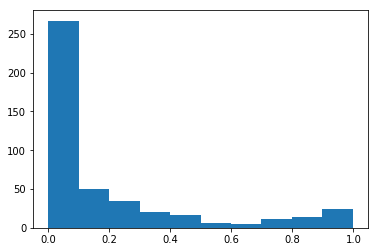

In [295]:
plt.hist(all_preds.mean(axis=0))

In [70]:
layer_vis = visualize_layer(hail_conv_net, 1, num_iter=100)
#layer_act = vis_act(hail_conv_net, gaussian_filter(layer_vis, 2))[0]

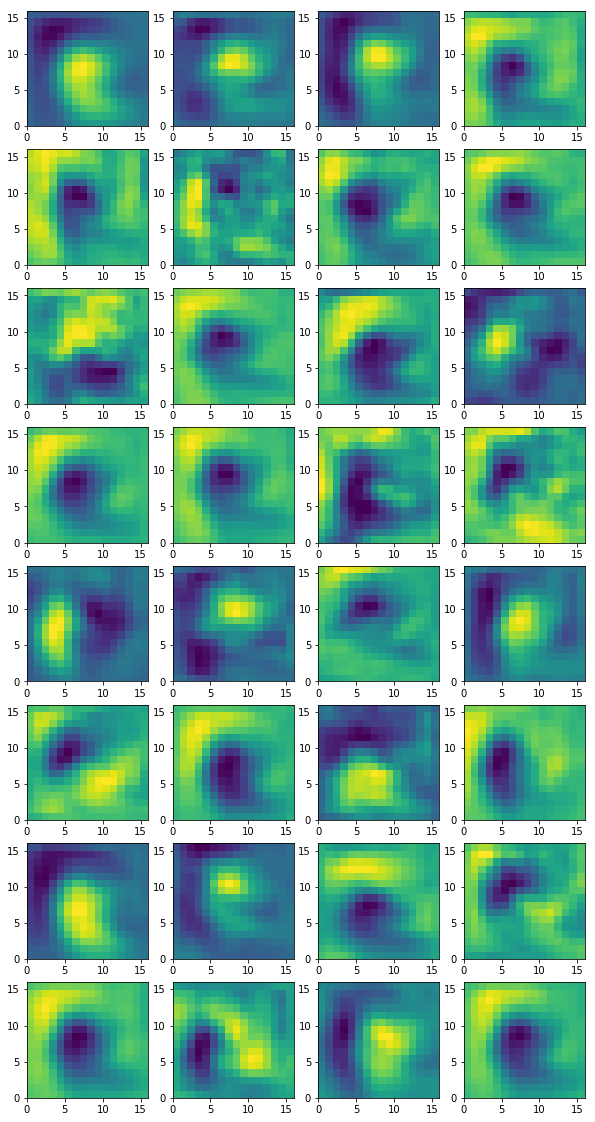

In [29]:
fig ,axes = plt.subplots(8, 4, figsize=(10, 20))
axef = axes.ravel()
for a in range(layer_act.shape[-1]):
    axef[a].pcolormesh(layer_act[0, :, :, a])

In [26]:
layer_act.shape

(1, 16, 16, 32)

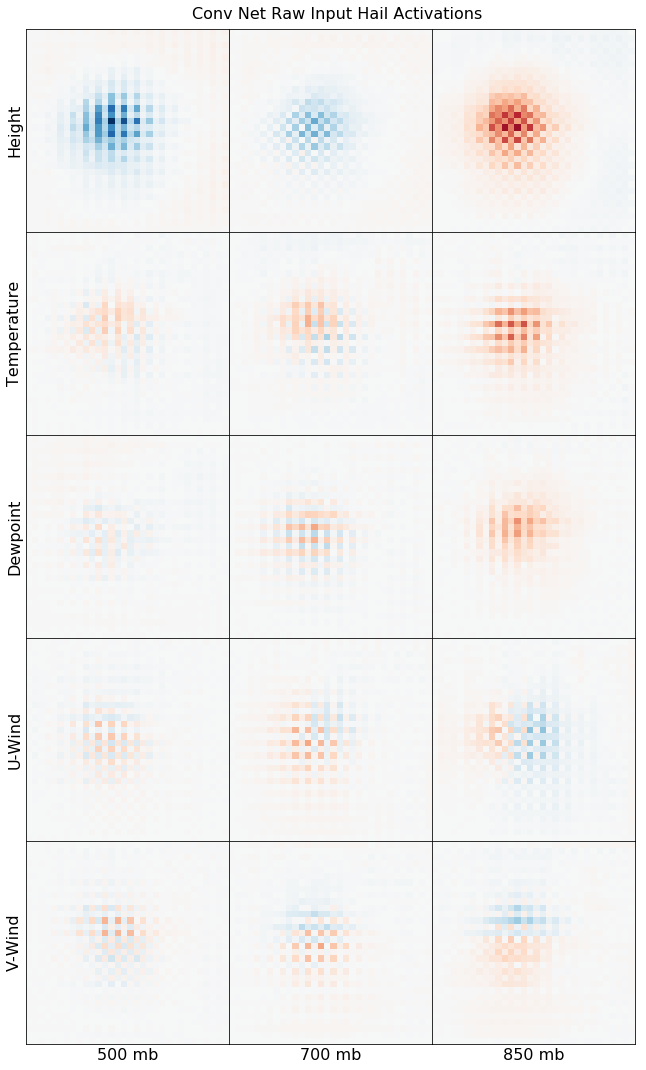

In [71]:
fig, axes = plt.subplots(5, 3, figsize=(9, 15), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.96, 0.96, hspace=0, wspace=0)
axef = axes.ravel()
v_max = np.abs(layer_vis).max()
for a, ax in enumerate(axef):
    ax.pcolormesh(layer_vis[0, :, :, a], vmin=-v_max, vmax=v_max, cmap="RdBu_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
all_vars = ["Height", "Temperature", "Dewpoint", "U-Wind", "V-Wind"]
levels = [500, 700, 850]
for v in range(5):
    axes[v, 0].set_ylabel(all_vars[v], fontsize=16)
for v in range(3):
    axes[-1, v].set_xlabel("{0:d} mb".format(levels[v]), fontsize=16)
fig.suptitle("Conv Net Raw Input Hail Activations", fontsize=16)
plt.savefig(join(out_path, "conv_net_raw_input_acts.png"), dpi=300, bbox_inches="tight")

0.473445990001 -7.94916280114
0.29503156928 -4.06072053637
6.96337133307 -0.444651856633
1.99709418612 -0.889734825461
2.87410478021 -1.8427110569
5.13349787619 -0.303342011017
0.601291273311 -1.05070426362
3.04419619671 -1.04062474121
3.63663156714 -0.208106876334
2.19354072439 -0.903950436958
3.10276154093 -1.75559439828
2.22641121217 -3.25760561161
2.75144149822 -1.35491355203
2.98006674563 -1.99890002875
1.82850661823 -2.83065926972


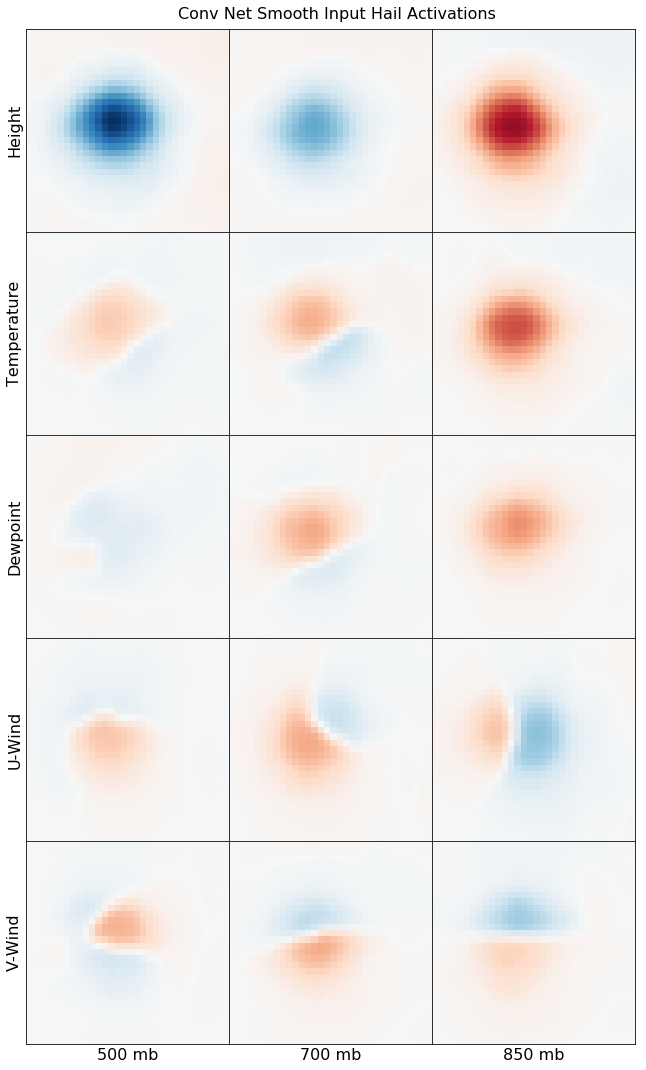

In [72]:
smooth_vis = smooth_channels(layer_vis)
smooth_vis /= smooth_vis.std()
fig, axes = plt.subplots(5, 3, figsize=(9, 15), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.96, 0.96, hspace=0, wspace=0)
axef = axes.ravel()
v_max = np.abs(smooth_vis).max()
for a, ax in enumerate(axef):
    print(smooth_vis[0, :, :, a].max(), smooth_vis[0, :, :, a].min())
    ax.pcolormesh(smooth_vis[0, :, :, a], vmin=-v_max, vmax=v_max, cmap="RdBu_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
all_vars = ["Height", "Temperature", "Dewpoint", "U-Wind", "V-Wind"]
levels = [500, 700, 850]
for v in range(5):
    axes[v, 0].set_ylabel(all_vars[v], fontsize=16)
for v in range(3):
    axes[-1, v].set_xlabel("{0:d} mb".format(levels[v]), fontsize=16)
fig.suptitle("Conv Net Smooth Input Hail Activations", fontsize=16)
plt.savefig(join(out_path, "conv_net_smooth_input_acts.png"), dpi=300, bbox_inches="tight")

(array([  13.,   17.,   24.,   25.,   40.,   45.,   59.,  141.,  323.,  337.]),
 array([-0.09212417, -0.08124903, -0.0703739 , -0.05949876, -0.04862362,
        -0.03774849, -0.02687335, -0.01599821, -0.00512308,  0.00575206,
         0.01662719]),
 <a list of 10 Patch objects>)

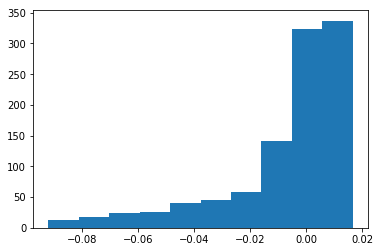

In [20]:
plt.hist(smooth_vis[0, :, :, 1].ravel())

Text(0.5,0.99,'Conv Net 02 Best Hailstorm')

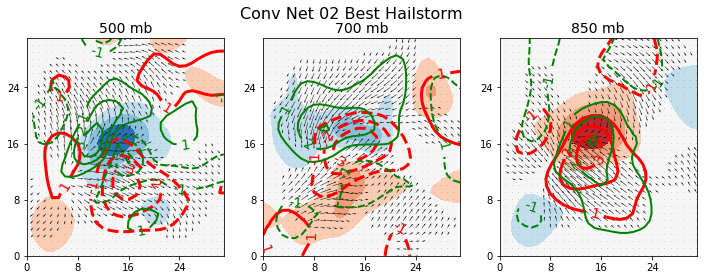

In [251]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght_g = gaussian_filter(all_vis_samples.mean(axis=0)[:, :, a], 2)
    hght = plt.contourf(hght_g / hght_g.std(), , extend="both", cmap="RdBu_r")
    tmpc_g = gaussian_filter(all_vis_samples.mean(axis=0)[:, :, 3 + a], 2)
    tmpc_g /= tmpc_g.std()
    tmpc = plt.contour(tmpc_g, 
                       [-3, -2, -1, 1, 2, 3], linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
    dewp_g = gaussian_filter(all_vis_samples.mean(axis=0)[ :, :, 6 + a], 2)
    dewp_g /= dewp_g.std()
    dewp = plt.contour(dewp_g, [-3, -2, -1,1,2,3], linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.0f", fontsize=14)
    u_g = gaussian_filter(all_vis_samples.mean(axis=0)[:, :, 9 + a], 2)
    u_g /= u_g.std()
    v_g = gaussian_filter(all_vis_samples.mean(axis=0)[:, :, 12 + a], 2)
    v_g /= v_g.std()
    wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 1
    u_g[wind_mask] = 0
    v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
#plt.savefig("/scratch/dgagne/spatial_hail_interp/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
#            dpi=300)

[-4.  -3.  -2.  -1.  -0.5  0.5  1.   2.   3.   4. ]
1.99709417505
2.87410477002
5.13349792995


Text(0.5,0.99,'Conv Net 03 Best Hailstorm')

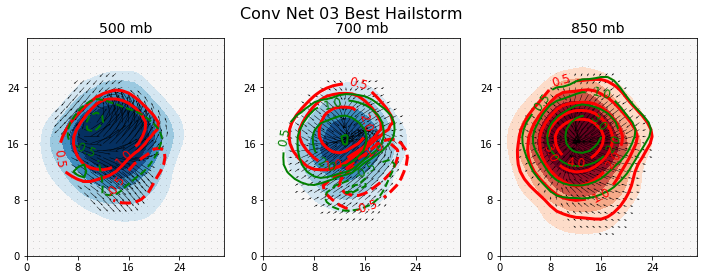

In [60]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
#conts = np.linspace(-4, 4, 9)
conts = np.array([-4, -3, -2, -1, -0.5, 0.5, 1, 2, 3, 4])
#conts = conts[conts != 0]
print(conts)
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght_g = smooth_vis[0, :, :, a]
    hght = plt.contourf(hght_g, conts, extend="both", cmap="RdBu_r")
    tempc_g = smooth_vis[0, :, :, 3 + a]
    print(tempc_g.max())
    tmpc = plt.contour(tempc_g, conts, 
                       linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.1f", fontsize=12)
    #dewp_g = gaussian_filter(layer_vis[0, :, :, 6 + a], 1)
    dewp_g = smooth_vis[0, :, :, 6 + a]
    dewp = plt.contour(dewp_g, conts, linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.1f", fontsize=12)
    #u_g = gaussian_filter(layer_vis[0, :, :, 9 + a], 1)
    #v_g = gaussian_filter(layer_vis[0, :, :, 12 + a], 1)
    u_g = smooth_vis[0, :, :, 9 + a]
    v_g = smooth_vis[0, :, :, 12 + a]
    wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 0.5
    u_g[wind_mask] = 0
    v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
#plt.savefig("/scratch/dgagne/spatial_hail_interp/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
#            dpi=300)

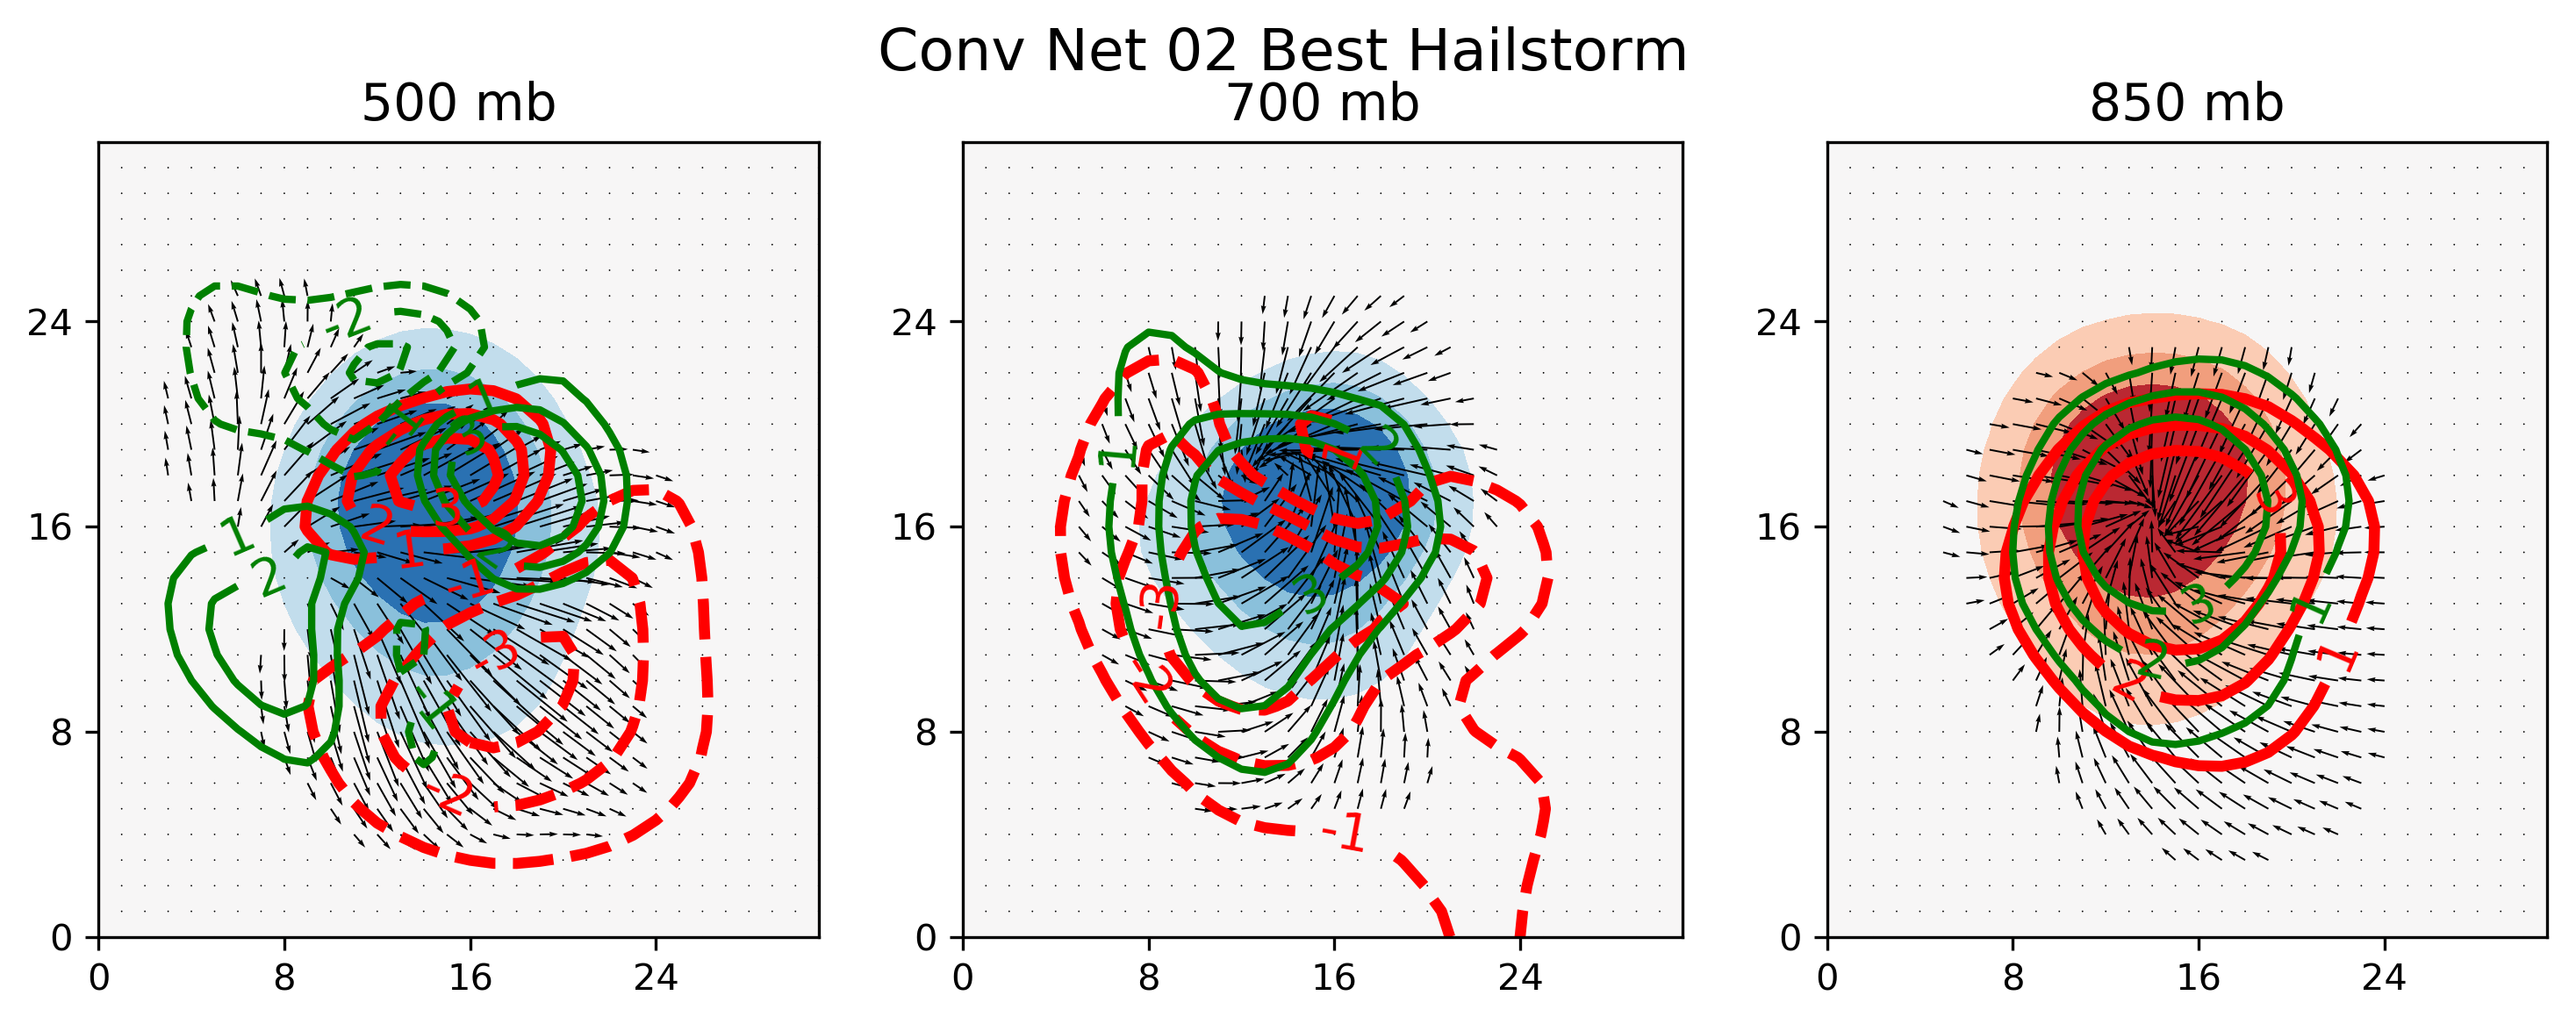

In [73]:
Image("/scratch/dgagne/spatial_hail_interp/best_hailstorm_002.png")

In [75]:
def plot_best_hailstorm(layer_vis, sample):
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        hght_g = gaussian_filter(layer_vis[0, :, :, a], 2)
        hght = plt.contourf(hght_g / hght_g.std(), [-6, -3, -2, -1, 1, 2, 3, 6], extend="both", cmap="RdBu_r")
        tmpc_g = gaussian_filter(layer_vis[0, :, :, 3 + a], 2)
        tmpc_g /= tmpc_g.std()
        tmpc = plt.contour(tmpc_g, 
                           [-3, -2, -1, 1, 2, 3], linewidths=3, colors=["red"])
        plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
        dewp_g = gaussian_filter(layer_vis[0, :, :, 6 + a], 2)
        dewp_g /= dewp_g.std()
        dewp = plt.contour(dewp_g, [-3, -2, -1,1,2,3], linewidths=2, colors=["green"])
        plt.clabel(dewp, fmt="%1.0f", fontsize=14)
        u_g = gaussian_filter(layer_vis[0, :, :, 9 + a], 2)
        u_g /= u_g.std()
        v_g = gaussian_filter(layer_vis[0, :, :, 12 + a], 2)
        v_g /= v_g.std()
        wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 1
        u_g[wind_mask] = 0
        v_g[wind_mask] = 0
        plt.quiver(np.arange(32), np.arange(32), u_g,
                  v_g, color="k")
        plt.xticks(np.arange(0, 32, 8))
        plt.yticks(np.arange(0, 32, 8))
        plt.title("{0:d} mb".format(heights[a]), fontsize=14)
    plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
    plt.savefig("/scratch/dgagne/spatial_hail_interp_smooth/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
                dpi=300)
    plt.close()

In [65]:
def plot_best_smooth_hailstorm(layer_vis, sample):
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    conts = np.array([-4, -3, -2, -1, 1, 2, 3, 4])
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        hght_g = layer_vis[0, :, :, a]
        hght = plt.contourf(hght_g, conts, extend="both", cmap="RdBu_r")
        tmpc_g = layer_vis[0, :, :, 3 + a]
        tmpc = plt.contour(tmpc_g, 
                           conts, linewidths=3, colors=["red"])
        plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
        dewp_g = layer_vis[0, :, :, 6 + a]
        dewp = plt.contour(dewp_g, conts, linewidths=2, colors=["green"])
        plt.clabel(dewp, fmt="%1.0f", fontsize=14)
        u_g = layer_vis[0, :, :, 9 + a]
        v_g = layer_vis[0, :, :, 12 + a]
        wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 1
        u_g[wind_mask] = 0
        v_g[wind_mask] = 0
        plt.quiver(np.arange(32), np.arange(32), u_g,
                  v_g, color="k")
        plt.xticks(np.arange(0, 34, 8))
        plt.yticks(np.arange(0, 34, 8))
        plt.title("{0:d} mb".format(heights[a]), fontsize=14)
    plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
    plt.savefig("/scratch/dgagne/spatial_hail_interp_smooth/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
                dpi=300)
    plt.close()

In [66]:
for sample in range(30):
    print(sample)
    model_name = "hail_conv_net_sample_{0:03d}.h5".format(sample)
    hail_conv_net = load_model(join(out_path, model_name))
    layer_vis = visualize_layer(hail_conv_net, 1, num_iter=100)
    smooth_vis = smooth_channels(layer_vis)
    plot_best_smooth_hailstorm(smooth_vis / smooth_vis.std(), sample)
    del hail_conv_net

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


27
28
29


-0.029305365731872545

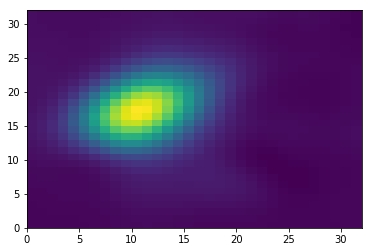

In [325]:
plt.pcolormesh(hght_g)
hght_g.min()

In [11]:
weights = hail_conv_net.layers[1].get_weights()[0]

0.0272985
0.0206638
0.0223501
0.0346958
0.0411052
0.046168
0.0330226
0.0418669
0.0415984
0.0386806
0.0333771
0.0453107
0.0264554
0.0284442
0.0356926


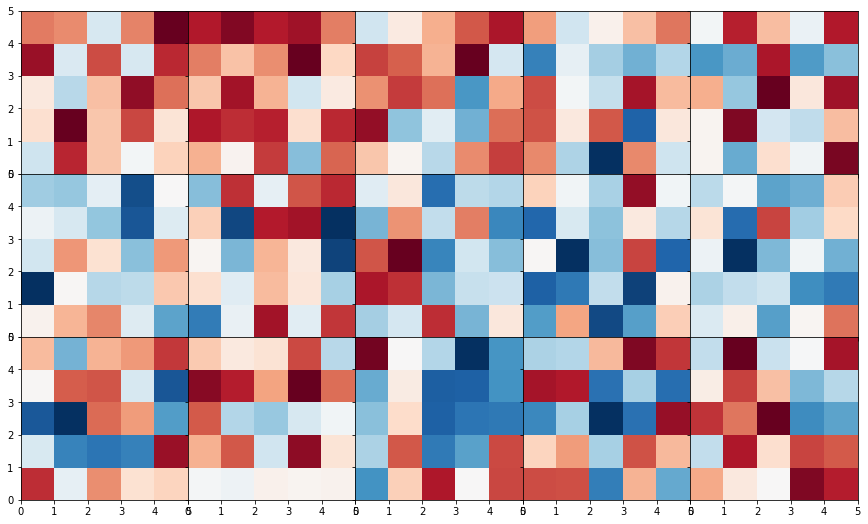

In [13]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
axef = axes.ravel()
filter_val = 0
for a, ax in enumerate(axef):
    v_max = np.abs(weights[:, :, a, filter_val]).max()
    print(v_max)
    ax.pcolormesh(weights[:, :, a, filter_val], vmin=-v_max, vmax=v_max, cmap="RdBu_r")

In [78]:
weights.max()

0.036789883

In [4]:
best_configs = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/conv_net_best_params.csv", index_col="Sample")

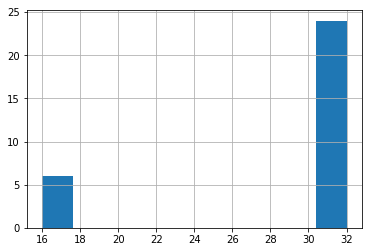

In [9]:
best_configs["min_conv_filters"].hist()

In [10]:
conv_sample_scores = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/conv_net_sample_scores.csv", index_col="Sample")
logistic_pca_sample_scores = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/logistic_pca_sample_scores.csv", index_col="Sample")

In [14]:
conv_sample_scores["Brier Skill Score"].sort_values()

Sample
21    0.320119
26    0.321711
29    0.327135
23    0.330821
22    0.340075
10    0.357390
6     0.360162
19    0.361567
8     0.362343
14    0.366586
3     0.368743
13    0.376773
28    0.377547
1     0.377699
7     0.380070
25    0.380620
9     0.380930
18    0.382524
5     0.384927
17    0.385474
20    0.385614
2     0.386731
11    0.389277
0     0.392856
4     0.393201
24    0.399263
27    0.404657
16    0.410758
15    0.417170
12    0.433790
Name: Brier Skill Score, dtype: float64

In [540]:
def bootstrap(values, n_boot=1000):
    boot_scores = np.zeros(n_boot)
    for b in range(n_boot):
        boot_vals = np.random.choice(values, size=values.size, replace=True)
        boot_scores[b] = boot_vals.mean()
    return boot_scores

In [546]:
conv_net_boot_auc = bootstrap(conv_sample_scores["AUC"].values)
logistic_pca_boot_auc = bootstrap(logistic_pca_sample_scores["AUC"].values)

In [547]:
np.percentile(conv_net_boot_auc, [1, 2.5, 5, 50, 95, 97.5, 99])

array([ 0.88254286,  0.88341001,  0.88414532,  0.88758912,  0.89097981,
        0.89163403,  0.89225845])

In [548]:
np.percentile(logistic_pca_boot_auc, [1, 2.5, 5, 50, 95, 97.5, 99])

array([ 0.84881464,  0.85004458,  0.85093743,  0.85587871,  0.86044694,
        0.86113192,  0.86257399])

In [549]:
conv_net_boot_bss = bootstrap(conv_sample_scores["Brier Skill Score"].values)
logistic_pca_boot_bss = bootstrap(logistic_pca_sample_scores["Brier Skill Score"].values)

In [550]:
np.percentile(conv_net_boot_bss, [1, 2.5, 5, 50, 95, 97.5, 99])

array([ 0.3633078 ,  0.36528531,  0.36701097,  0.37552957,  0.38346286,
        0.38452086,  0.3866319 ])

In [552]:
np.percentile(logistic_pca_boot_bss, [1, 2.5, 5, 50, 95, 97.5, 99, 99.9])

array([ 0.29280831,  0.29422272,  0.29571756,  0.30437548,  0.31241507,
        0.3137975 ,  0.31478265,  0.31842529])

In [553]:
conv_sample_scores

,Brier Score,Brier Score Climo,Brier Skill Score,AUC
Sample,,,,
0,0.085811,0.141335,0.392856,0.896425
1,0.092550,0.148723,0.377699,0.896318
2,0.082178,0.134000,0.386731,0.885710
3,0.101475,0.160750,0.368743,0.872207
4,0.089099,0.146835,0.393201,0.890249
5,0.085663,0.139273,0.384927,0.898119
6,0.095748,0.149644,0.360162,0.879635
7,0.091436,0.147494,0.380070,0.879603
8,0.094411,0.148059,0.362343,0.885974


In [231]:
score_path = "/scratch/dgagne/spatial_storm_results_20171220/"
score_file = "predictions_{0}_sample_{1:03d}.csv"
rocs = {}
rels = {}
models = ["logistic_mean", "logistic_pca", "logistic_gan", "conv_net"]
model_names = ["Logistic Mean", "Logistic PCA", "Logistic GAN", "Conv Net"]
samples = np.arange(30)
#thresholds = np.arange(0, 1.1, 0.1)
thresholds = np.concatenate([[0, 0.01, 0.05], np.arange(0.1, 1.1, 0.1)])
for model in models:
    print(model)
    rocs[model] = []
    rels[model] = []
    for sample in samples:
        preds = pd.read_csv(join(score_path, score_file.format(model, sample)))
        rocs[model].append(DistributedROC(thresholds=thresholds))
        rels[model].append(DistributedReliability(thresholds=thresholds))
        rocs[model][-1].update(preds[model], preds["label"])
        rels[model][-1].update(preds[model], preds["label"])
        del preds

logistic_mean
logistic_pca
logistic_gan
conv_net


In [63]:
sample = 2
conv_net_preds = pd.read_csv(join(score_path, score_file.format("conv_net", sample)), index_col="Index")
logistic_mean_preds = pd.read_csv(join(score_path, score_file.format("logistic_mean", sample)), index_col="Index")
shared_preds = pd.merge(conv_net_preds, logistic_mean_preds, on=["run_dates", "valid_dates", "members", 
                                                                 "center_lon", "center_lat", "label"])

In [64]:
shared_preds

,center_lon,center_lat,valid_dates,run_dates,members,conv_net,label,logistic_mean
0,-77.659683,35.436363,2016-05-05 17:00:00,2016050500,1,0.296301,0,0.176771
1,-77.277847,35.550411,2016-05-05 18:00:00,2016050500,1,0.680359,1,0.171817
2,-77.000275,35.658287,2016-05-05 19:00:00,2016050500,1,0.669862,0,0.243864
3,-121.299522,41.808769,2016-05-05 19:00:00,2016050500,1,0.910299,1,0.190096
4,-120.480530,41.305290,2016-05-05 20:00:00,2016050500,1,0.787463,1,0.304339
5,-119.763794,39.532375,2016-05-05 21:00:00,2016050500,1,0.245617,0,0.301757
6,-120.479134,41.555683,2016-05-05 21:00:00,2016050500,1,0.881214,1,0.264349
7,-119.894432,41.982449,2016-05-05 21:00:00,2016050500,1,0.809119,1,0.388099
8,-112.382378,40.507401,2016-05-05 22:00:00,2016050500,1,0.011789,0,0.033662
9,-119.759865,39.782948,2016-05-05 22:00:00,2016050500,1,0.354425,0,0.208240


In [61]:
np.intersect1d(logistic_mean_preds["run_dates"].unique(), conv_net_preds["run_dates"].unique())

array([2016050500, 2016050800, 2016051300, 2016051500, 2016051700,
       2016051800])

(array([[  3.58800000e+03,   2.33700000e+03,   8.08000000e+02,
           3.91000000e+02,   2.01000000e+02,   1.25000000e+02,
           5.30000000e+01,   2.70000000e+01,   2.00000000e+00,
           0.00000000e+00],
        [  1.83000000e+02,   3.33000000e+02,   2.15000000e+02,
           1.78000000e+02,   1.02000000e+02,   7.90000000e+01,
           5.20000000e+01,   2.10000000e+01,   1.40000000e+01,
           1.00000000e+00],
        [  6.80000000e+01,   1.57000000e+02,   1.21000000e+02,
           1.28000000e+02,   7.40000000e+01,   6.00000000e+01,
           4.20000000e+01,   2.60000000e+01,   8.00000000e+00,
           1.00000000e+00],
        [  3.70000000e+01,   9.90000000e+01,   1.01000000e+02,
           8.80000000e+01,   6.00000000e+01,   5.70000000e+01,
           2.60000000e+01,   2.50000000e+01,   8.00000000e+00,
           0.00000000e+00],
        [  2.50000000e+01,   5.80000000e+01,   7.10000000e+01,
           4.20000000e+01,   3.80000000e+01,   3.90000000e+01,
      

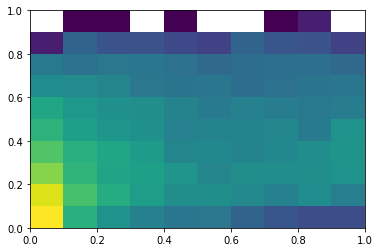

In [66]:
from matplotlib.colors import LogNorm
plt.hist2d(shared_preds["conv_net"].values, 
           shared_preds["logistic_mean"].values, bins=np.arange(0, 1.1, 0.1),
           norm=LogNorm())

In [232]:
boot_rocs = []
boot_rels = []
mean_rocs = []
mean_rels = []
for model in models:
    print(model)
    print("Boot ROCS")
    boot_rocs.append(bootstrap(rocs[model]))
    print("Boot Rels")
    boot_rels.append(bootstrap(rels[model]))
    print("Mean ROCs and Rels")
    mean_rocs.append(np.sum(rocs[model]))
    mean_rels.append(np.sum(rels[model]))

logistic_mean
Boot ROCS
Boot Rels
Mean ROCs and Rels
logistic_pca
Boot ROCS
Boot Rels
Mean ROCs and Rels
logistic_gan
Boot ROCS
Boot Rels
Mean ROCs and Rels
conv_net
Boot ROCS
Boot Rels
Mean ROCs and Rels


In [233]:
for m, model in enumerate(models):
    print(model, mean_rocs[m].auc())
    
for m, model in enumerate(models):
    print(model, mean_rels[m].brier_skill_score())

for m, model in enumerate(models):
    bs_c = mean_rels[m].brier_score_components()
    print(model, bs_c[0] / bs_c[2], bs_c[1] / bs_c[2])

logistic_mean 0.752301433767
logistic_pca 0.849116306234
logistic_gan 0.784895940184
conv_net 0.879583490149
logistic_mean 0.115100394893
logistic_pca 0.292326521568
logistic_gan 0.181847217927
conv_net 0.359202209043
logistic_mean 0.01659509505 0.131695489943
logistic_pca 0.00820042031138 0.300526941879
logistic_gan 0.011089626059 0.192936843986
conv_net 0.0194798769467 0.37868208599


In [6]:
[x.brier_skill_score() for x in mean_rels]

[0.11510039489282003,
 0.29232652156757233,
 0.18184721792677619,
 0.35920220904337774]

In [7]:
[x.brier_score_components() for x in mean_rels]

[(0.0024344145598196015, 0.01931904681549633, 0.14669482473452392),
 (0.0011671107369011027, 0.042771980859119589, 0.14232328253733684),
 (0.0016031076731283891, 0.027890799327006659, 0.14455921819196291),
 (0.0028159957818888852, 0.054741986294025602, 0.14455921819196291)]

In [234]:
def roc_curve(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
              xlabel="Probability of Correct Negative",
              ylabel="Probability of Detection",
              title="ROC Curve", ticks=np.arange(0, 1.1, 0.1), dpi=300,
              legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Plots a set receiver/relative operating characteristic (ROC) curves from DistributedROC objects.

    The ROC curve shows how well a forecast discriminates between two outcomes over a series of thresholds. It
    features Probability of Detection (True Positive Rate) on the y-axis and Probability of False Detection
    (False Alarm Rate) on the x-axis. This plotting function allows one to customize the colors and markers of the
    ROC curves as well as the parameters of the legend and the title.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.

    Examples:

        >>> from hagelslag.evaluation import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> roc_curve([roc], ["Random"], ["orange"], ["o"], "random_roc.png")
    """
    if legend_params is None:
        legend_params = dict(loc=0, fontsize=12, framealpha=1, frameon=True)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(ticks, 1 - ticks, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            broc_curves = np.dstack([b_roc.roc_curve().values for b_roc in b_set])
            pod_range = np.percentile(broc_curves[:,0], ci, axis=1)
            pofd_range = np.percentile(broc_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            pofd_poly = np.concatenate((pofd_range[0], pofd_range[1, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            pofd_poly[np.isnan(pofd_poly)] = 0
            plt.fill(1 - pofd_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        roc_data = roc_obj.roc_curve()
        plt.plot(1-roc_data["POFD"], roc_data["POD"], marker=markers[r], color=colors[r], label=obj_labels[r])
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks, fontsize=14)
    plt.yticks(ticks, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()
    
def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Draws a performance diagram from a set of DistributedROC objects.

    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles

    Examples:

        >>> from hagelslag.evaluation import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=0, fontsize=10, framealpha=1, frameon=True)
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7), (0.9, 0.4)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], label=obj_labels[r])
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks, fontsize=14)
    plt.yticks(ticks, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()

In [230]:
mean_rocs

NameError: name 'mean_rocs' is not defined

In [236]:
model_colors = ["blue", "crimson", "green", "purple"]
model_markers = ["o", "o", "v", "v"]
roc_curve(mean_rocs, model_names, model_colors, model_markers, 
          "/scratch/dgagne/spatial_storm_results_20171220/hail_roc_gtc.pdf", 
          title="Severe Hail ROC Curves", 
          figsize=(6,6),
          bootstrap_sets=boot_rocs)

In [237]:
performance_diagram(mean_rocs, model_names, model_colors, model_markers,
                   "/scratch/dgagne/spatial_storm_results_20171220/hail_perf_gtc.pdf",
                   title="Severe Hail Performance Diagram",
                    figsize=(6, 6),
                   legend_params={"loc":0, "fontsize":12, "frameon": True, "framealpha": 1}, bootstrap_sets=boot_rocs)


/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: divide by zero encountered in true_divide
/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in true_divide
/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in true_divide
/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [235]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
def attributes_diagram(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300,
                       title="Attributes Diagram", legend_params=None, inset_params=None,
                       inset_position=(0.12, 0.72, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Plot reliability curves against a 1:1 diagonal to determine if probability forecasts are consistent with their
    observed relative frequency. Also adds gray areas to show where the climatological probabilities lie and what
    areas result in a positive Brier Skill Score.

    Args:
        rel_objs (list): List of DistributedReliability objects.
        obj_labels (list): List of labels describing the forecast model associated with each curve.
        colors (list): List of colors for each line
        markers (list): List of line markers
        filename (str): Where to save the figure.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        ticks (array): Tick value labels for the x and y axes.
        dpi (int): resolution of the saved figure in dots per inch.
        title (str): Title of figure
        legend_params (dict): Keyword arguments for the plot legend.
        inset_params (dict): Keyword arguments for the inset axis.
        inset_position (tuple): Position of the inset axis in normalized axes coordinates (left, bottom, width, height)
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    if inset_params is None:
        inset_params = dict(width="25%", height="25%", loc=2, axes_kwargs=dict(facecolor='white'))
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    inset_hist = inset_axes(ax, **inset_params)
    ip = InsetPosition(ax, inset_position)
    inset_hist.set_axes_locator(ip)
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    f = ax.fill(skill_x, skill_y, "0.8")
    f[0].set_zorder(1)
    ax.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            brel_curves = np.vstack([b_rel.reliability_curve()["Positive_Relative_Freq"].values for b_rel in b_set])
            rel_range = np.nanpercentile(brel_curves, ci, axis=0)
            fb = ax.fill_between(rel_objs[b].reliability_curve()["Bin_Center"], rel_range[1], rel_range[0], alpha=0.5, color=colors[b])
            fb.set_zorder(2)
    for r, rel_obj in enumerate(rel_objs):
        rel_curve = rel_obj.reliability_curve()
        ax.plot(rel_curve["Bin_Center"], rel_curve["Positive_Relative_Freq"], color=colors[r],
                marker=markers[r], label=obj_labels[r])
        inset_hist.semilogy(rel_curve["Bin_Center"] * 100, rel_obj.frequencies["Total_Freq"][:-1], color=colors[r],
                            marker=markers[r])
        inset_hist.set_xticks(np.arange(0, 120, 20))
    inset_hist.set_xlabel("Forecast Probability")
    inset_hist.set_ylabel("Frequency")
    ax.annotate("No Skill", (0.6, no_skill[int(len(ticks) / 2)]), rotation=22.5, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int), fontsize=14)
    ax.set_yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int), fontsize=14)
    ax.legend(**legend_params)
    ax.set_title(title, fontsize=16)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()


In [238]:
attributes_diagram(mean_rels, model_names, model_colors, model_markers,
                  "/scratch/dgagne/spatial_storm_results_20171220/hail_rel_gtc.pdf",
                   title="Severe Hail Attributes Diagram",
                   ticks=np.arange(0, 1.1, 0.1),
                   figsize=(6, 6),
                   bootstrap_sets=boot_rels)

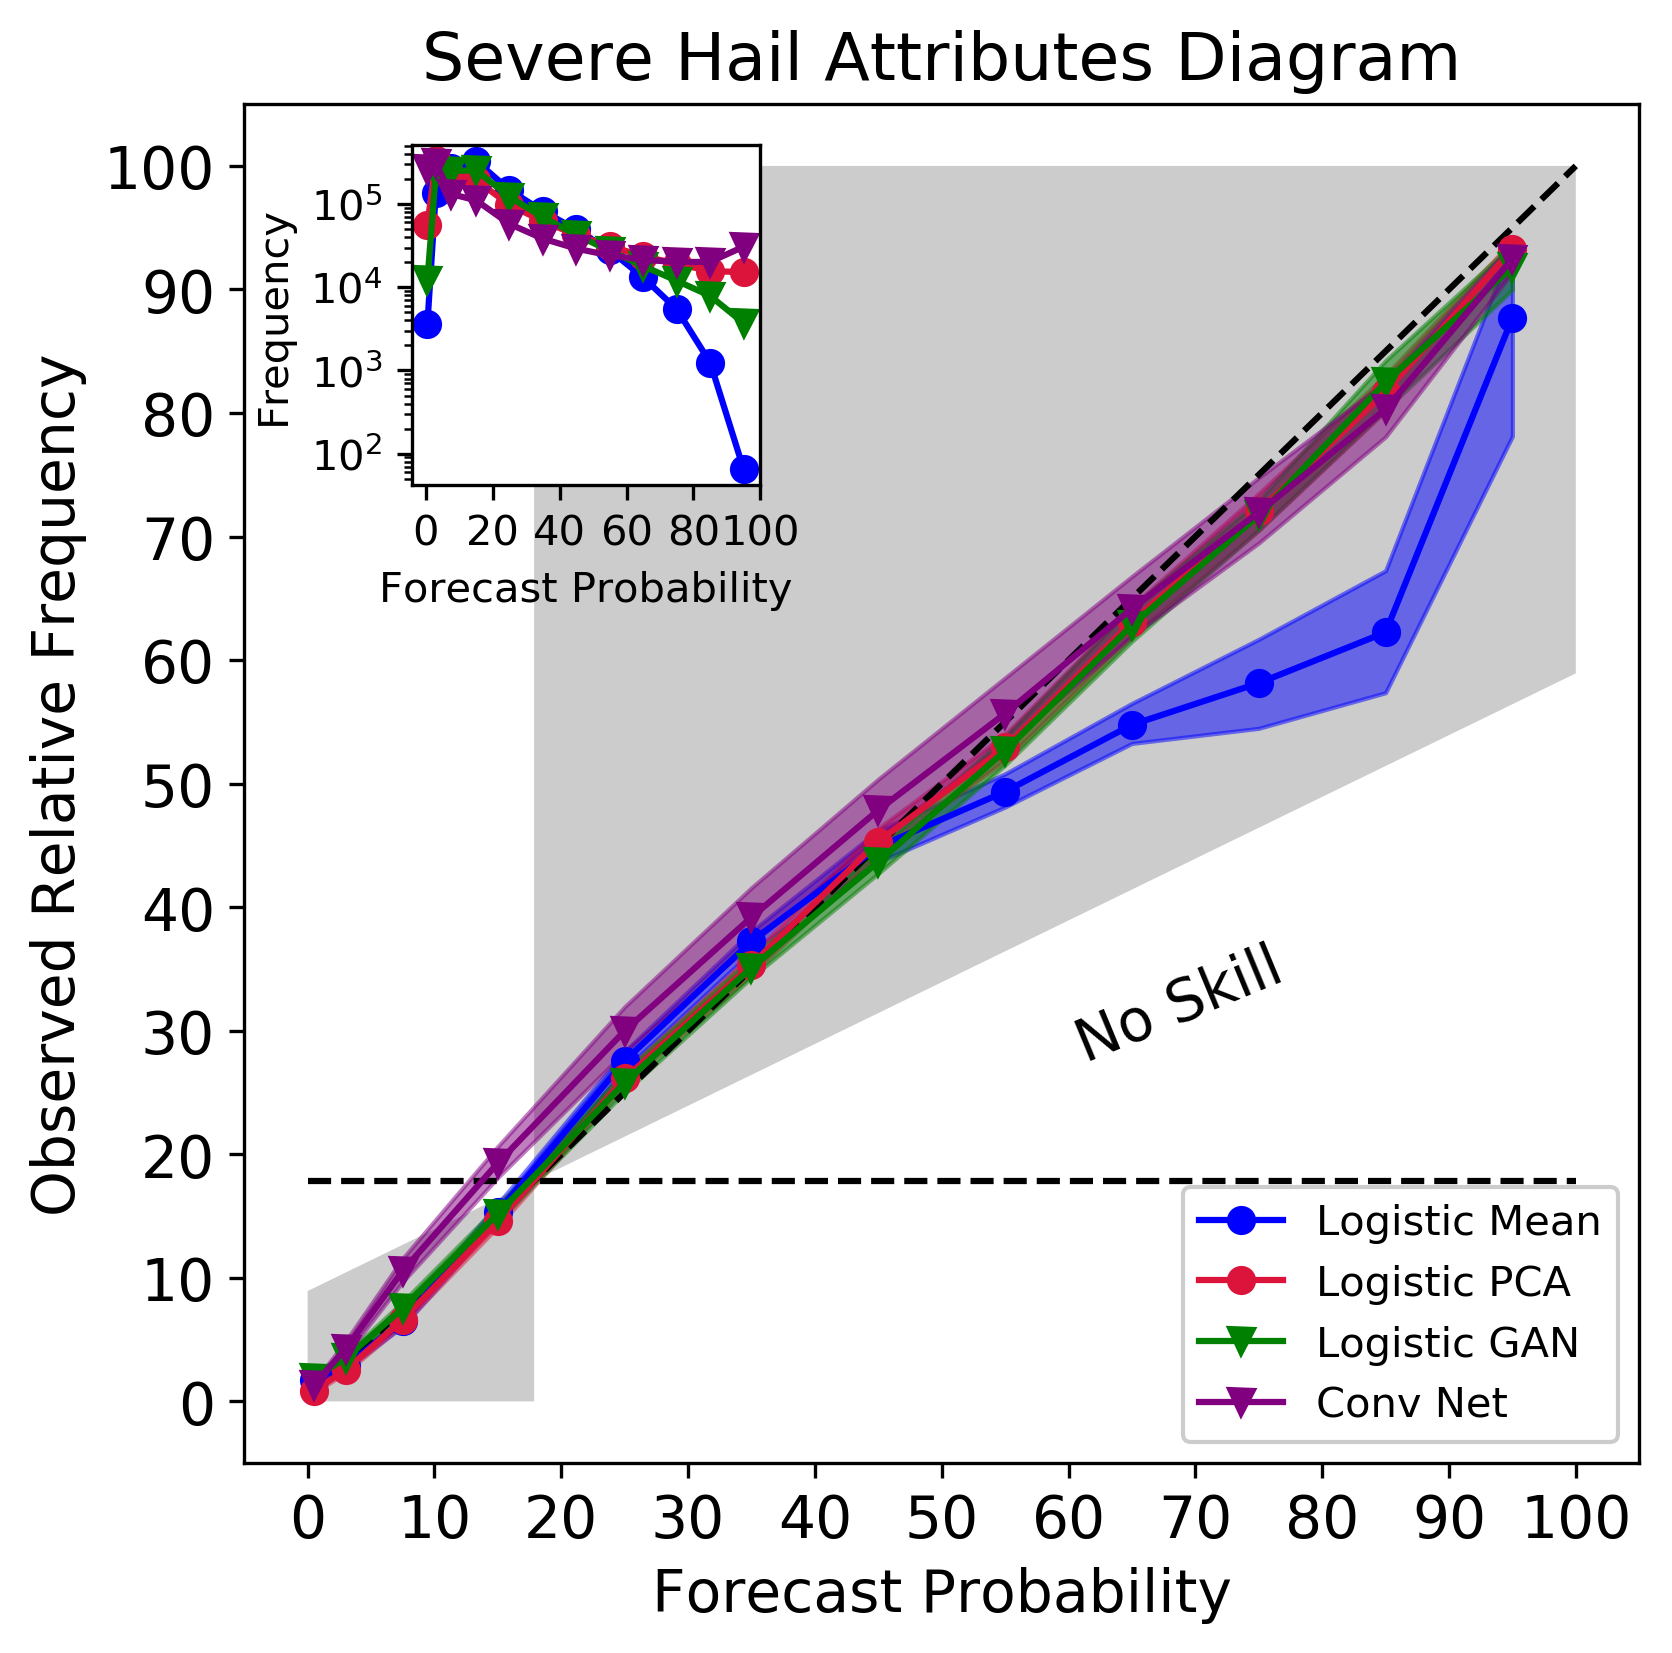

In [36]:
Image("/scratch/dgagne/spatial_storm_results_20171220/hail_rel_gtc.png")

In [38]:
mean_rels[0].brier_score_components()

(0.0033938457554600473, 0.019203896692637487, 0.14669482473452392)

In [25]:
def load_storm_data_file(data_file, variable_names):
    try:
        run_filename = data_file.split("/")[-1][:-3].split("_")
        member = int(run_filename[6])
        run_date = run_filename[4]
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        meta_cols = ["center_lon", "center_lat", "valid_dates", "run_dates", "members"]
        return_dict = {"data_file": data_file, "meta": None, "data_patches": None}
        if np.all(np.in1d(variable_names, all_vars)):
            meta_dict = {}
            meta_dict["center_lon"] = ds["longitude"][:, 32, 32].values
            meta_dict["center_lat"] = ds["latitude"][:, 32, 32].values
            meta_dict["valid_dates"] = pd.DatetimeIndex(ds["valid_date"].values)
            meta_dict["run_dates"] = np.tile(run_date, meta_dict["valid_dates"].size)
            meta_dict["members"] = np.tile(member, meta_dict["valid_dates"].size)
            return_dict["meta"] = pd.DataFrame(meta_dict, columns=meta_cols)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values.astype(np.float32))
            return_dict["data_patches"] = np.stack(patch_arr, axis=-1)
            print(data_file, return_dict["meta"].size)
        ds.close()
        del patch_arr[:]
        del patch_arr
        del ds
        return return_dict
    except Exception as e:
        print(traceback.format_exc())
        raise e

In [21]:
with open("/scratch/dgagne/deepsky/config/spatial_storm_model_config.yaml") as config_file:
    config = yaml.load(config_file)

In [22]:
config

{'conv_net': {'activation': ['leaky', 'relu'],
  'batch_size': [128],
  'data_width': [32],
  'dropout_alpha': [0.1, 0.3],
  'filter_growth_rate': [2],
  'filter_width': [5],
  'learning_rate': [0.001, 0.0001],
  'loss': ['mse'],
  'metrics': [['mae']],
  'min_conv_filters': [16, 32],
  'min_data_width': [4],
  'num_epochs': [15],
  'num_gpus': [8],
  'num_input_channels': [15],
  'optimizer': ['sgd', 'adam'],
  'regularization_alpha': [0.01, 0.001]},
 'data_path': '/scratch/dgagne/ncar_ens_storm_patches/',
 'input_variables': ['geopotential_height_500_mb_prev',
  'geopotential_height_700_mb_prev',
  'geopotential_height_850_mb_prev',
  'temperature_500_mb_prev',
  'temperature_700_mb_prev',
  'temperature_850_mb_prev',
  'dew_point_temperature_500_mb_prev',
  'dew_point_temperature_700_mb_prev',
  'dew_point_temperature_850_mb_prev',
  'u-component_of_wind_500_mb_prev',
  'u-component_of_wind_700_mb_prev',
  'u-component_of_wind_850_mb_prev',
  'v-component_of_wind_500_mb_prev',
  'v-

In [23]:
config["input_variables"]

['geopotential_height_500_mb_prev',
 'geopotential_height_700_mb_prev',
 'geopotential_height_850_mb_prev',
 'temperature_500_mb_prev',
 'temperature_700_mb_prev',
 'temperature_850_mb_prev',
 'dew_point_temperature_500_mb_prev',
 'dew_point_temperature_700_mb_prev',
 'dew_point_temperature_850_mb_prev',
 'u-component_of_wind_500_mb_prev',
 'u-component_of_wind_700_mb_prev',
 'u-component_of_wind_850_mb_prev',
 'v-component_of_wind_500_mb_prev',
 'v-component_of_wind_700_mb_prev',
 'v-component_of_wind_850_mb_prev']

In [26]:
patch_data = load_storm_data_file("/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052400_mem_01.nc", config["input_variables"])

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052400_mem_01.nc 2245


In [110]:
label_data = load_storm_data_file("/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052400_mem_01.nc", [config["output"]["variable"], "mask"])

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052400_mem_01.nc 2245


In [114]:
max_hail_sizes = (label_data["data_patches"][:, :, :, 0] * label_data["data_patches"][:, :, :, 1]).max(axis=-1).max(axis=-1) * 1000

In [115]:
max_hail_sizes.argmax()

31

In [55]:
scale_values = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/scaling_values.csv", index_col="Index")

In [56]:
scale_values

,mean,std
Index,,
0,5788.919434,65.136246
1,3109.552979,49.678848
2,1481.663574,45.307823
3,261.454987,2.581064
4,279.288055,2.373210
5,289.850830,2.915570
6,253.631378,8.898883
7,274.562805,4.148108
8,285.562958,3.813218


In [62]:
norm_data, sv = normalize_multivariate_data(patch_data["data_patches"], scaling_values=scale_values)

In [77]:
norm_data[30]

array([[[  1.25413015e-01,  -1.68082669e-01,  -3.89267862e-01, ...,
          -1.46522775e-01,   1.04035604e+00,   1.30925551e-01],
        [  1.27376437e-01,  -1.66679740e-01,  -3.90067220e-01, ...,
          -1.67268798e-01,   1.10201728e+00,   1.48289800e-01],
        [  1.29339844e-01,  -1.64575353e-01,  -3.89267862e-01, ...,
          -1.77641809e-01,   1.15134633e+00,   1.74336180e-01],
        ..., 
        [  1.77934319e-01,  -2.00739074e-02,  -2.14211613e-01, ...,
          -1.05030723e-01,   6.70388103e-01,   8.42859864e-01],
        [  1.75480053e-01,   9.69992252e-04,  -2.04619482e-01, ...,
          -9.46577042e-02,   6.33391321e-01,   8.34177792e-01],
        [  1.72044083e-01,   1.42977955e-02,  -1.94228023e-01, ...,
          -7.39116818e-02,   7.07384884e-01,   7.73402870e-01]],

       [[  1.22467898e-01,  -1.73694372e-01,  -3.94063950e-01, ...,
          -1.67268798e-01,   1.05268824e+00,   1.56971931e-01],
        [  1.23449609e-01,  -1.72291443e-01,  -3.94863278e-0

In [165]:
def saliency(cnn_model, data, labels):
    print(labels)
    layer_out = cnn_model.layers[-1].output
    input_image = cnn_model.layers[0].input
    label_tensor = K.variable(labels)
    loss = (label_tensor - K.flatten(layer_out)) ** 2
    grads = K.gradients(loss, input_image)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [loss, grads])
    out_grid = np.zeros(data.shape)
    out_grid[:] = data[:]
    for i in range(20):
        loss_value, grads_value = iterate([out_grid, True])
        print(loss_value)
        out_grid -= 0.01 * grads_value
    return out_grid

In [166]:
hail_sal = saliency(hail_conv_net, norm_data[0:1], np.array([1]))

[1]
[ 0.4364863]
[ 0.26203111]
[ 0.24905622]
[ 0.0142278]
[ 0.01327388]
[ 0.00323365]
[ 0.00047315]
[ 0.02680684]
[  7.24382480e-05]
[ 0.00028224]
[  6.22029766e-05]
[  3.84475861e-05]
[ 0.00316429]
[  6.29626675e-06]
[ 0.00069228]
[ 0.00045808]
[ 0.0002939]
[  8.87219358e-06]
[  4.49800245e-05]
[  2.17851921e-05]


Text(0.5,0.99,'Conv Net 02 Saliency')

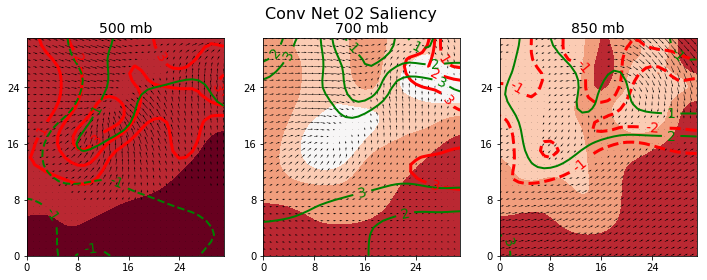

In [167]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
ind = 0
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght_g = gaussian_filter(hail_sal[ind, :, :, a], 2)
    hght = plt.contourf(hght_g / hght_g.std(), [-6, -3, -2, -1, 1, 2, 3, 6], extend="both", cmap="RdBu_r")
    tmpc_g = gaussian_filter(hail_sal[ind, :, :, 3 + a], 2)
    tmpc_g /= tmpc_g.std()
    tmpc = plt.contour(tmpc_g, 
                       [-3, -2, -1, 1, 2, 3], linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
    dewp_g = gaussian_filter(hail_sal[0, :, :, 6 + a], 2)
    dewp_g /= dewp_g.std()
    dewp = plt.contour(dewp_g, [-3, -2, -1,1,2,3], linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.0f", fontsize=14)
    u_g = gaussian_filter(hail_sal[ind, :, :, 9 + a], 2)
    u_g /= u_g.std()
    v_g = gaussian_filter(hail_sal[ind, :, :, 12 + a], 2)
    v_g /= v_g.std()
    wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 1
    u_g[wind_mask] = 0
    v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Saliency".format(sample), fontsize=16, y=0.99)

Text(0.5,0.99,'Conv Net 02 Saliency')

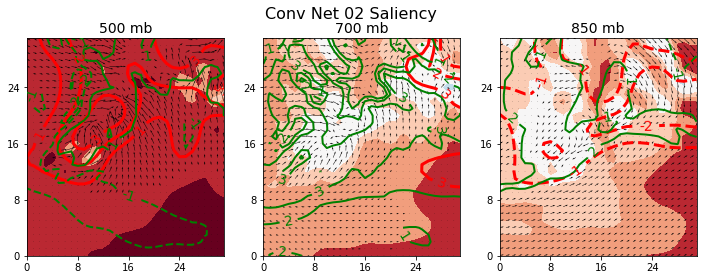

In [160]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
ind = 0
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght_g = gaussian_filter(norm_data[ind, :, :, a], 0)
    hght = plt.contourf(hght_g / hght_g.std(), [-6, -3, -2, -1, 1, 2, 3, 6], extend="both", cmap="RdBu_r")
    tmpc_g = gaussian_filter(norm_data[ind, :, :, 3 + a], 2)
    tmpc_g /= tmpc_g.std()
    tmpc = plt.contour(tmpc_g, 
                       [-3, -2, -1, 1, 2, 3], linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
    dewp_g = gaussian_filter(norm_data[0, :, :, 6 + a], 0)
    dewp_g /= dewp_g.std()
    dewp = plt.contour(dewp_g, [-3, -2, -1,1,2,3], linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.0f", fontsize=14)
    u_g = gaussian_filter(norm_data[ind, :, :, 9 + a], 0)
    u_g /= u_g.std()
    v_g = gaussian_filter(norm_data[ind, :, :, 12 + a], 0)
    v_g /= v_g.std()
    wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 1
    u_g[wind_mask] = 0
    v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Saliency".format(sample), fontsize=16, y=0.99)

0.692839
0.929872
0.768157
2.83604
1.32905
1.68335
1.66014
2.00929
1.83708
2.99783
3.42281
3.50743
3.14172
4.26252
3.28115


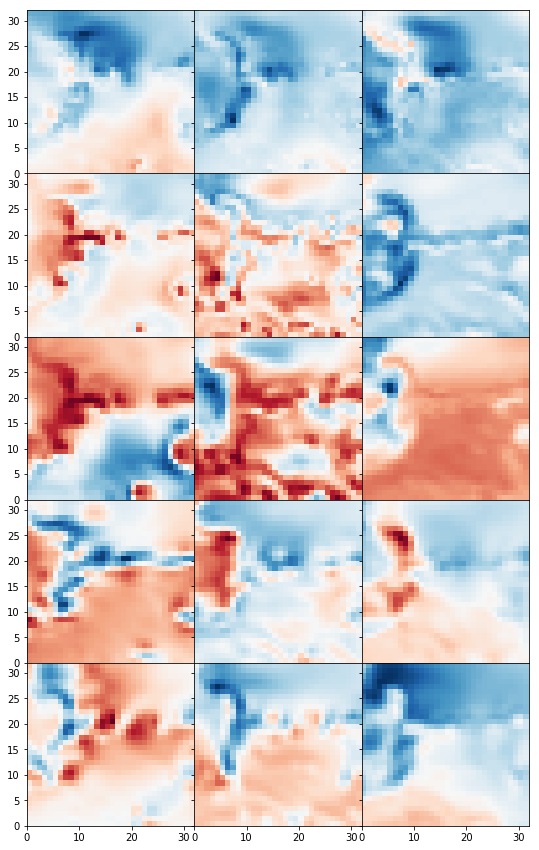

In [118]:
fig, axes = plt.subplots(5, 3, figsize=(9, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    gf = gaussian_filter(norm_data[31, :, :, a], 0)
    v_max = np.abs(gf).max()
    print(v_max)
    ax.pcolormesh(gf, vmin=-v_max, vmax=v_max, cmap="RdBu_r")

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


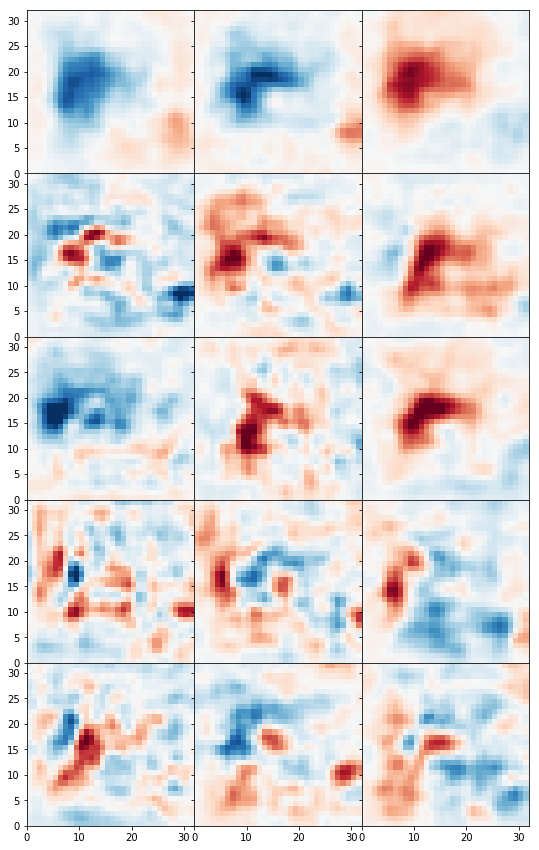

In [126]:
fig, axes = plt.subplots(5, 3, figsize=(9, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    gf = gaussian_filter(hail_sal[31, :, :, a], 1)
    v_max = 4
    print(v_max)
    ax.pcolormesh(gf / gf.std(), vmin=-v_max, vmax=v_max, cmap="RdBu_r")

In [116]:
max_hail_sizes[31]

78.589996

In [300]:
ls /scratch/dgagne/spatial_storm_results_20171220/*.npy

/scratch/dgagne/spatial_storm_results_20171220/best_test_data.npy
/scratch/dgagne/spatial_storm_results_20171220/best_train_data.npy
/scratch/dgagne/spatial_storm_results_20171220/param_train_data.npy
/scratch/dgagne/spatial_storm_results_20171220/param_train_labels.npy
/scratch/dgagne/spatial_storm_results_20171220/param_val_data.npy
/scratch/dgagne/spatial_storm_results_20171220/param_val_labels.npy


In [303]:
data = np.load("/scratch/dgagne/spatial_storm_results_20171220/best_test_data.npy")

In [304]:
data.shape

(32045, 32, 32, 15)

In [3]:
ls "/scratch/dgagne/spatial_storm_results_20171220/"

best_test_data.npy                    logistic_gan_4_params.yaml
best_train_data.npy                   logistic_gan_5_discriminator.h5
conv_net_best_params.csv              logistic_gan_5_encoder.h5
conv_net_param_combos.csv             logistic_gan_5_generator.h5
conv_net_param_scores_sample_000.csv  logistic_gan_5_logistic.pkl
conv_net_param_scores_sample_001.csv  logistic_gan_5_params.yaml
conv_net_param_scores_sample_002.csv  logistic_gan_6_discriminator.h5
conv_net_param_scores_sample_003.csv  logistic_gan_6_encoder.h5
conv_net_param_scores_sample_004.csv  logistic_gan_6_generator.h5
conv_net_param_scores_sample_005.csv  logistic_gan_6_logistic.pkl
conv_net_param_scores_sample_006.csv  logistic_gan_6_params.yaml
conv_net_param_scores_sample_007.csv  logistic_gan_7_discriminator.h5
conv_net_param_scores_sample_008.csv  logistic_gan_7_encoder.h5
conv_net_param_scores_sample_009.csv  logistic_gan_7_generator.h5
conv_net_param_scores_sample_010.csv  logistic_gan_7_logistic.pkl
conv_ne

In [16]:
def load_storm_data_file(data_file, variable_names):
    try:
        run_filename = data_file.split("/")[-1][:-3].split("_")
        member = int(run_filename[6])
        run_date = run_filename[4]
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        meta_cols = ["center_lon", "center_lat", "valid_dates", "run_dates", "members"]
        return_dict = {"data_file": data_file, "meta": None, "data_patches": None}
        if np.all(np.in1d(variable_names, all_vars)):
            meta_dict = {}
            meta_dict["center_lon"] = ds["longitude"][:, 32, 32].values
            meta_dict["center_lat"] = ds["latitude"][:, 32, 32].values
            meta_dict["valid_dates"] = pd.DatetimeIndex(ds["valid_date"].values)
            meta_dict["run_dates"] = np.tile(run_date, meta_dict["valid_dates"].size)
            meta_dict["members"] = np.tile(member, meta_dict["valid_dates"].size)
            return_dict["meta"] = pd.DataFrame(meta_dict, columns=meta_cols)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values.astype(np.float32))
            return_dict["data_patches"] = np.stack(patch_arr, axis=-1)
            print(data_file, return_dict["meta"].size)
        ds.close()
        del patch_arr[:]
        del patch_arr
        del ds
        return return_dict
    except Exception as e:
        print(traceback.format_exc())
        raise e


def load_storm_patch_data(data_path, variable_names, n_procs):
    data_patches = []
    data_meta = []
    
    data_files = sorted(glob(join(data_path, "*.nc")))
    pool = Pool(n_procs, maxtasksperchild=1)
    outputs = []
    file_check = data_files[:]
    def combine_storm_data_files(return_obj):
        f_index = file_check.index(return_obj["data_file"])
        if return_obj["meta"] is not None:
            data_patches[f_index] = return_obj["data_patches"]
            data_meta[f_index] = return_obj["meta"]
        else:
            file_check.pop(f_index)
            data_patches.pop(f_index)
            data_meta.pop(f_index)
    for data_file in data_files:
        data_patches.append(None)
        data_meta.append(None)
        pool.apply_async(load_storm_data_file, (data_file, variable_names), callback=combine_storm_data_files)
    pool.close()
    pool.join()
    del pool
    all_data = np.vstack(data_patches)
    all_meta = pd.concat(data_meta, ignore_index=True)
    return all_data, all_meta

In [39]:
def cnn_variable_importance(data, labels, variable_names, cnn_model, permutations=30):
    cnn_preds = cnn_model.predict(data)[:, 0]
    cnn_bs = np.mean((cnn_preds - labels) ** 2)
    print(cnn_bs)
    indices = np.arange(cnn_preds.shape[0])
    perm_data = np.copy(data)
    score_diff = pd.DataFrame(index=np.arange(permutations), columns=variable_names, dtype=float)
    for v, variable in enumerate(variable_names):
        print(variable)
        for p in range(permutations):
            np.random.shuffle(indices)
            perm_data[:, :, :, v] = data[indices, :, :, v]
            perm_preds = cnn_model.predict(perm_data)[:, 0]
            perm_bs = np.mean((perm_preds - labels) ** 2)
            score_diff.loc[p, variable] = (perm_bs - cnn_bs) / cnn_bs
        perm_data[:, :, :, v] = data[:, :, :, v]
        print(variable, score_diff[variable].mean(), score_diff[variable].std())
    return score_diff

In [21]:
config_file = "/scratch/dgagne/deepsky/config/spatial_storm_model_config.yaml"
with open(config_file, "r") as c_file:
    config = yaml.load(c_file)

In [22]:
config

{'conv_net': {'activation': ['leaky', 'relu'],
  'batch_size': [128],
  'data_width': [32],
  'dropout_alpha': [0.1, 0.3],
  'filter_growth_rate': [2],
  'filter_width': [5],
  'learning_rate': [0.001, 0.0001],
  'loss': ['mse'],
  'metrics': [['mae']],
  'min_conv_filters': [16, 32],
  'min_data_width': [4],
  'num_epochs': [15],
  'num_gpus': [8],
  'num_input_channels': [15],
  'optimizer': ['sgd', 'adam'],
  'regularization_alpha': [0.01, 0.001]},
 'data_path': '/scratch/dgagne/ncar_ens_storm_patches/',
 'input_variables': ['geopotential_height_500_mb_prev',
  'geopotential_height_700_mb_prev',
  'geopotential_height_850_mb_prev',
  'temperature_500_mb_prev',
  'temperature_700_mb_prev',
  'temperature_850_mb_prev',
  'dew_point_temperature_500_mb_prev',
  'dew_point_temperature_700_mb_prev',
  'dew_point_temperature_850_mb_prev',
  'u-component_of_wind_500_mb_prev',
  'u-component_of_wind_700_mb_prev',
  'u-component_of_wind_850_mb_prev',
  'v-component_of_wind_500_mb_prev',
  'v-

In [23]:
storm_data, storm_meta = load_storm_patch_data(config["data_path"], config["input_variables"], 2)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/scratch/dgagne/ncar_ens_storm_patches/ncar

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_05.nc 1305
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_06.nc 1260
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_07.nc 1265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_08.nc 1270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_09.nc 1185
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_10.nc 1470
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_02.nc 1140
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_03.nc 995
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_04.nc 825
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_05.nc 1025
/scratch/dgagne/ncar_ens_storm_pat

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_09.nc 1685
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_10.nc 1770
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_01.nc 1985
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_02.nc 2170
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_03.nc 2220
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_04.nc 2065
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_05.nc 2160
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_06.nc 2530
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_07.nc 2415
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_08.nc 2270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_09.nc 1870
/scratch/dgagne/ncar_ens_storm_p

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_03.nc 2265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_04.nc 2430
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_05.nc 2695
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_06.nc 2200
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_07.nc 2050
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_08.nc 2400
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_09.nc 2395
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_01.nc 2000
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_10.nc 2805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_02.nc 1850
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_03.nc 1955
/scratch/dgagne/ncar_ens_storm_p

In [28]:
storm_norm_data, storm_scaling_values = normalize_multivariate_data(storm_data)

In [32]:
test_preds = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/predictions_conv_net_sample_000.csv", index_col="Index")

In [56]:
all_dates = storm_meta["run_dates"].unique().astype("U10")
test_dates = test_preds["run_dates"].unique().astype("U10")
train_dates = all_dates[~np.isin(all_dates, test_dates)]

In [63]:
np.in1d(storm_meta["run_dates"], test_dates).sum()

36723

In [40]:
importance_scores = []
out_path = "/scratch/dgagne/spatial_storm_results_20171220/"
num_samples = 30
for sample in range(num_samples):
    print(sample)
    model_name = "hail_conv_net_sample_{0:03d}.h5".format(sample)
    hail_conv_net = load_model(join(out_path, model_name))
    sample_preds = pd.read_csv(out_path + "predictions_conv_net_sample_000.csv", index_col="Index")
    importance_scores.append(cnn_variable_importance(storm_norm_data[sample_preds.index.values], 
                                                     sample_preds["label"].values,
                                                     config["input_variables"],
                                                     hail_conv_net))

0
geopotential_height_500_mb_prev
geopotential_height_500_mb_prev 1.644423402807483 0.012177124037829662
geopotential_height_700_mb_prev
geopotential_height_700_mb_prev 0.5251122610472849 0.006613442645198761
geopotential_height_850_mb_prev
geopotential_height_850_mb_prev 1.6981975894858115 0.013781094400338048
temperature_500_mb_prev
temperature_500_mb_prev 0.14621457934551257 0.004199553654208588
temperature_700_mb_prev
temperature_700_mb_prev 0.42618070338053493 0.007425194528121938
temperature_850_mb_prev
temperature_850_mb_prev 0.42635504443674427 0.0073031574919382855
dew_point_temperature_500_mb_prev
dew_point_temperature_500_mb_prev 0.08134076744158297 0.003123655469827639
dew_point_temperature_700_mb_prev
dew_point_temperature_700_mb_prev 0.04348268263713117 0.0025911473878644513
dew_point_temperature_850_mb_prev
dew_point_temperature_850_mb_prev 0.24992314858299233 0.00558768975649805
u-component_of_wind_500_mb_prev
u-component_of_wind_500_mb_prev 0.03145815439308822 0.002564

KeyboardInterrupt: 

In [42]:
hail_conv_net

(36723,)

In [108]:
input_variables = ["geopotential_height_500_mb_prev",
                   "geopotential_height_700_mb_prev",
                   "geopotential_height_850_mb_prev",
                   "temperature_500_mb_prev",
                   "temperature_700_mb_prev",
                   "temperature_850_mb_prev",
                   "dew_point_temperature_500_mb_prev",
                   "dew_point_temperature_700_mb_prev",
                   "dew_point_temperature_850_mb_prev",
                   "u-component_of_wind_500_mb_prev",
                   "u-component_of_wind_700_mb_prev",
                   "u-component_of_wind_850_mb_prev",
                   "v-component_of_wind_500_mb_prev",
                   "v-component_of_wind_700_mb_prev",
                   "v-component_of_wind_850_mb_prev"]
storm_data, storm_meta = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", input_variables, 6)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc 325
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/scratch/dgagne/ncar_ens_storm_patches/ncar

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_06.nc 1260
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_05.nc 1305
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_07.nc 1265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_09.nc 1185
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_08.nc 1270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_02.nc 1140
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_10.nc 1470
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_04.nc 825
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_03.nc 995
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_05.nc 1025
/scratch/dgagne/ncar_ens_storm_pat

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_09.nc 1685
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_10.nc 1770
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_01.nc 1985
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_02.nc 2170
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_03.nc 2220
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_04.nc 2065
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_05.nc 2160
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_07.nc 2415
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_06.nc 2530
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_08.nc 2270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_09.nc 1870
/scratch/dgagne/ncar_ens_storm_p

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_03.nc 2265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_04.nc 2430
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_06.nc 2200
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_05.nc 2695
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_07.nc 2050
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_08.nc 2400
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_09.nc 2395
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_10.nc 2805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_01.nc 2000
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_02.nc 1850
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_03.nc 1955
/scratch/dgagne/ncar_ens_storm_p

In [110]:
storm_norm_data, scaling_values = normalize_multivariate_data(storm_data)

In [207]:
sample = 16
model_name = "hail_conv_net_sample_{0:03d}.h5".format(sample)
hail_conv_net = load_model(join(out_path, model_name))
hail_cnn = hail_conv_net

In [173]:
hail_conv_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
__________

Text(0,0.5,'Frequency')

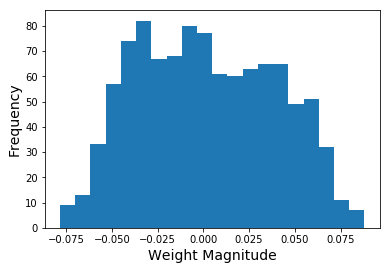

In [223]:
weights = hail_conv_net.layers[-2].get_weights()[0].ravel()
plt.hist(weights, 20)
plt.xlabel("Weight Magnitude", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

In [220]:
hail_cnn = hail_conv_net
weights = hail_cnn.layers[-2].get_weights()[0].ravel()
num_top = 10
num_ex = 4
top_neurons = weights.argsort()[::-1][0:num_top]
top_examples = np.zeros((num_top, num_ex), dtype=int)
top_gradients = np.zeros((num_top, num_ex, 32, 32, 15))

for n, neuron in enumerate(top_neurons):
    with K.tf.device("/gpu:1"):
        print(n, neuron, weights[neuron])
        act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:, neuron]])
        loss = 0.5 * (hail_cnn.layers[-3].output[:, neuron] - 4) ** 2
        grads = K.gradients(loss, hail_cnn.input)[0]
        grads /= K.maximum(K.std(grads), K.epsilon())
        #grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
        grad_func = K.function([hail_cnn.input, K.learning_phase()], [grads])
    act_values = np.zeros(storm_norm_data.shape[0])
    s_indices = np.linspace(0, storm_norm_data.shape[0], 20).astype(int)
    print(s_indices.max(), storm_norm_data.shape[0])
    for i in range(1, len(s_indices)):
        act_values[s_indices[i-1]: s_indices[i]] = act_func([storm_norm_data[s_indices[i-1]: s_indices[i]], 0])[0]
    top_examples[n] = act_values.argsort()[::-1][0:num_ex]
    top_gradients[n] = -grad_func([storm_norm_data[top_examples[n]],0])[0]

0 992 0.0880209
114229 114229
1 40 0.0876457
114229 114229
2 0 0.0838109
114229 114229
3 972 0.0837568
114229 114229
4 551 0.0832186
114229 114229
5 998 0.0821955
114229 114229
6 542 0.0812575
114229 114229
7 44 0.0770249
114229 114229
8 1023 0.0758741
114229 114229
9 11 0.0749411
114229 114229


In [216]:
np.sort(weights)[::-1][0:10]

array([ 0.08802088,  0.0876457 ,  0.0838109 ,  0.08375684,  0.08321857,
        0.08219548,  0.08125751,  0.07702491,  0.07587409,  0.0749411 ], dtype=float32)

In [181]:
def plot_best_ex_hailstorm(layer_vis, sample):
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    conts = np.array([-4, -3, -2, -1, 1, 2, 3, 4])
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        hght_g = layer_vis[0, :, :, a]
        hght = plt.contourf(hght_g, conts, extend="both", cmap="RdBu_r")
        tmpc_g = layer_vis[0, :, :, 3 + a]
        tmpc = plt.contour(tmpc_g, 
                           conts, linewidths=3, colors=["red"])
        plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
        dewp_g = layer_vis[0, :, :, 6 + a]
        dewp = plt.contour(dewp_g, conts, linewidths=2, colors=["green"])
        plt.clabel(dewp, fmt="%1.0f", fontsize=14)
        u_g = layer_vis[0, :, :, 9 + a]
        v_g = layer_vis[0, :, :, 12 + a]
        wind_mask = np.sqrt(u_g ** 2 + v_g ** 2) < 1
        u_g[wind_mask] = 0
        v_g[wind_mask] = 0
        plt.quiver(np.arange(32), np.arange(32), u_g,
                  v_g, color="k")
        plt.xticks(np.arange(0, 34, 8))
        plt.yticks(np.arange(0, 34, 8))
        plt.title("{0:d} mb".format(heights[a]), fontsize=14)
    plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
    #plt.savefig("/scratch/dgagne/spatial_hail_interp_smooth/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
    #            dpi=300)
    #plt.close()

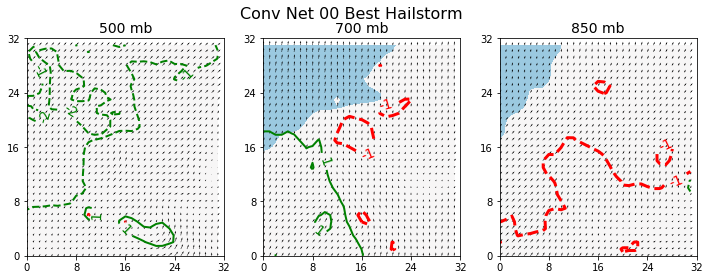

In [182]:
plot_best_ex_hailstorm(storm_norm_data[top_examples[1,0:1], :, :, :], 0)

In [150]:
top_gradients.shape

(10, 9, 32, 32, 15)

/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,0.98,'Conv Net Top Activated Example Neuron 4')

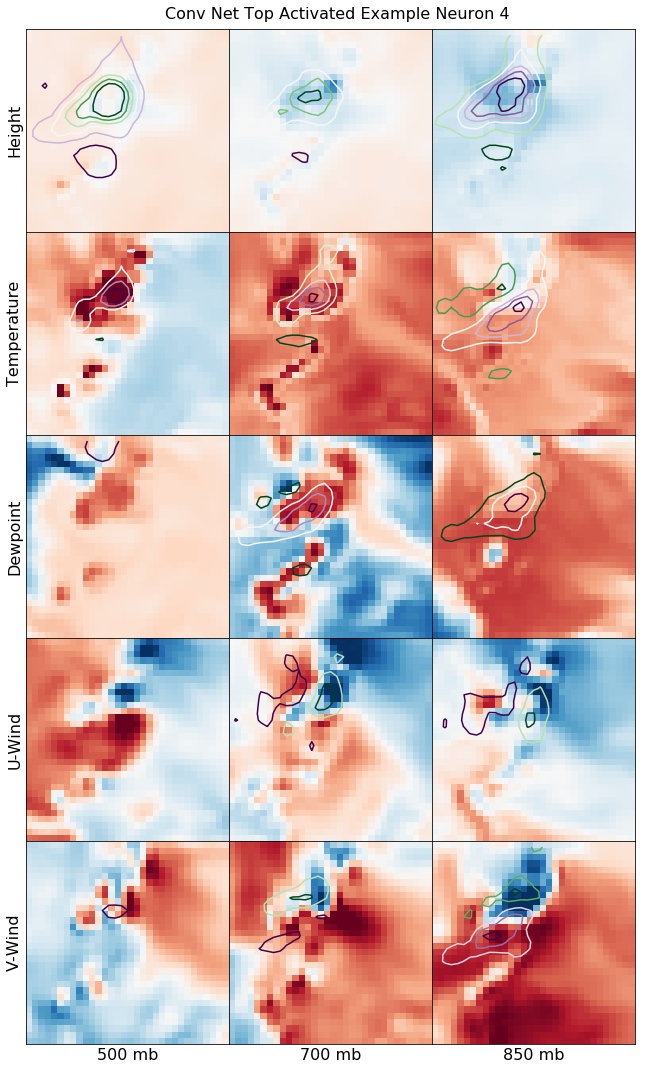

In [227]:
fig, axes = plt.subplots(5, 3, figsize=(9, 15), sharex=True, sharey=True)
plt.subplots_adjust(0.02, 0.02, 0.96, 0.96, hspace=0, wspace=0)
axef = axes.ravel()
#v_max = np.abs(storm_norm_data[top_examples[0,0]]).max()
n_index = 4
rank_index = 0
v_max = np.abs(storm_norm_data[top_examples[n_index,rank_index]]).max()
for a, ax in enumerate(axef):
    ax.pcolormesh(storm_norm_data[top_examples[n_index,rank_index], :, :, a], vmin=-3, vmax=3, cmap="RdBu_r")
    ax.contour(gaussian_filter(top_gradients[n_index, rank_index, :, :, a], 1), [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
               cmap="PRGn")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
all_vars = ["Height", "Temperature", "Dewpoint", "U-Wind", "V-Wind"]
levels = [500, 700, 850]
for v in range(5):
    axes[v, 0].set_ylabel(all_vars[v], fontsize=16)
for v in range(3):
    axes[-1, v].set_xlabel("{0:d} mb".format(levels[v]), fontsize=16)
fig.suptitle("Conv Net Top Activated Example Neuron {0:d}".format(n_index), fontsize=16)
#plt.savefig(join(out_path, "conv_net_raw_input_acts.png"), dpi=300, bbox_inches="tight")

In [189]:
top_gradients[n_index, rank_index, :, :, 3].min()

-6.3833861351013184

In [201]:
sample_scores = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/conv_net_sample_scores.csv")

In [205]:
sample_scores["Brier Skill Score"]

0     0.392856
1     0.377699
2     0.386731
3     0.368743
4     0.393201
5     0.384927
6     0.360162
7     0.380070
8     0.362343
9     0.380930
10    0.357390
11    0.389277
12    0.433790
13    0.376773
14    0.366586
15    0.417170
16    0.410758
17    0.385474
18    0.382524
19    0.361567
20    0.385614
21    0.320119
22    0.340075
23    0.330821
24    0.399263
25    0.380620
26    0.321711
27    0.404657
28    0.377547
29    0.327135
Name: Brier Skill Score, dtype: float64